In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

#Preprocessing
from scipy.stats import pearsonr, mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#Models
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#random state
randState = 0

#functions to chose data set and embeddings type:

# Choose data set
def chooseData(data = "BIG5"): #choose big5 or ipip ### dataset paths   
  folder = data.upper() + "/"
  data = data.lower() + "_"
  return folder, data

#Choose embeddings type
def chooseEmb(emb = "USE"): #choose big5 or ipip ### dataset paths   
  embeddings = "questions_embeddings_" + emb.upper() +  ".csv"
  save = "_" + emb.upper() +  ".csv"
  return embeddings, save

#choose prediction model
def predModel(nr=1,par=1):
  if nr == 1:
    model = RidgeClassifier(alpha=par, random_state=randState)
    modName = "RidgeClass"
  elif nr==2:  
    model = KNeighborsClassifier(n_neighbors=par)
    modName = "KNN"
  elif nr==3:
    model = SVC(C=par, random_state=randState)
    modName = "SVC"
  elif nr==4:  
    model = KNeighborsRegressor(n_neighbors=par)
    modName = "KnnReg"
  elif nr == 0:
    model = Ridge(alpha=par, random_state=randState)
    modName = "Ridge"
  print("running {}: ".format(modName))
  return model, modName 

#choose reversed or non reversed data
def getResponses(folder, data, R=1):
  if R == 1:
    res = "responses.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    savePath = "results/"+folder+"reversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)
  else:
    res = "responses_nonReversed.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    responses.columns.name = ""
    savePath = "results/"+folder+"nonReversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)

  return responses.astype(float), savePath, items, items_ids 

### Import functions: embeddings & response data


In [2]:
def getEmbeddings(folder, data, embeddings):
  #read in embeddings, order them like the response data and save in vector
  embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
  question_ids = responses.columns  #get IDs of questions answered

  # only get embeddings of questions having answers in matrix
  embeddings_df = embeddings_df.loc[question_ids,:]
  # save to vector 
  X = embeddings_df.values

  ################################ Preprocess input data::
  #Standardize for regression (wihtout PCA)
  X_stand = pd.DataFrame(StandardScaler().fit_transform(X),index=question_ids) #standardize embeddings
  #With PCA, for regression, 90% variance explained
  X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=question_ids) 

  return embeddings_df, X_stand, X_pca

def getData(m):
  
  question_ids = responses.columns
  data_q = X_pca_stand
  
  #choose parameter range
  if m==2 or m==4:  #KNN and KNN Regression
    list_par = [1,5,10,15,30,50] #parameter search
  elif m>=4:  #Random forest, extreme forest, gaussian
    list_par = [data_q.shape[1]] #parameter search
  else:  #Ridge, SVC
    list_par = [10**x for x in range(6)] #parameter search

  constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constrAssigned = constructs.loc[data_q.index,:] #only take constructs/encodings of items with embeddings
  constructs_list = constrAssigned.construct.drop_duplicates().values
  data_q = data_q.loc[constrAssigned.index,:] #only keep items that have an assigned construct

  return data_q, constructs_list, list_par, constrAssigned

### Accuracy functions

In [1]:
def correlate(x,y): #pooled items performance
  corr_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  l1_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
    #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    y_pred_constr = x.iloc[:,constr_idx]   #get predictions
    y_test_constr = y.loc[y_pred_constr.index,questions[constr_idx]]    #get label
    y_pred_match = y_pred_constr.values.flatten('F') #convert to 1D array
    y_test_match = y_test_constr.values.flatten('F')
    y_pred_match = y_pred_match[~pd.isnull(y_test_match)] #drop nan values, important for IPIP
    y_test_match = y_test_match[~pd.isnull(y_test_match)]

    #calculate correlation
    corr = np.round(pearsonr(y_pred_match,y_test_match),2)
    corr_constr.iloc[:,nr] = corr[0]
    l1 = np.round(sum(np.abs(y_pred_match-y_test_match))/len(y_test_match),2)
    l1_constr.iloc[:,nr] = l1

  y_pred = x.values.flatten()
  y_test = y.loc[y_pred_constr.index,:].values.flatten()
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]

  corr_total, pval_total = np.round(pearsonr(y_pred,y_test),3)
  l1_total = np.round(sum(np.abs(y_pred-y_test))/len(y_test),3)
  return list(corr_constr.mean()), corr_total, pval_total, list(l1_constr.mean()), l1_total

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def corrUserBased(x,y):
  #calculate correlations and p value for every person, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[0],3),fill_value=0),index = x.index,columns=["Correlation","p-value","L1 Loss"])
  
  #new function, much faster, #NOT FOR IPIP, #adjust for p value of averages
  corrVals = x.corrwith(y, 1, method=lambda x, y: np.round(pearsonr(x, y), 6)).fillna(0)
  results.iloc[:,:2] = corrVals.values.tolist()
  results.iloc[:,2] = np.absolute(x - y).sum(1)/x.shape[1] 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0, #change to make n decimals!
  mean, ci_lower, ci_upper = mean_confidence_interval(results.Correlation)
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss'].mean(), ci_lower, ci_upper, t, results.shape[0]-1]

def corrAggregateScores(x,y): 
  #calculate correlations and p value for average user response:
  results = pd.DataFrame(np.full(shape=(constructs_list.shape[0],3),fill_value=0),index = constructs_list.tolist(), columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
      #labels and predictions for current construct 
      #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    A = x.iloc[:,constr_idx].mean(1)
    B = y.iloc[:,constr_idx].mean(1)
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[nr] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

def corrQuestionBased(x,y):
  #calculate correlations and p value for every question, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[1],3),fill_value=0), index = x.columns,columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  #get correlation across participants for each question
  for i in range(x.shape[1]):
    A = x.loc[~pd.isnull(y.iloc[:,i]), x.columns[i]] #predicted responses for question "i" over all participants who answered said question
    B = y.loc[~pd.isnull(y.iloc[:,i]), y.columns[i]] #actual    responses for question "i" over all participants who answered said question
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[i] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

# accuracy (percentage of correct classifications)
def accuracy_constr(x,y, constructs_list): #do we report the construct wise accuracy? we could otherwise use a heatmap!
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct accuracy
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions,:].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total #list(metric_constr.mean()), metric_total

def accuracy_constr_comparison(x,y, constructs_total):
  constructs_total = constructs_total[x.index] #reorder according to x
  constructs_list = constructs_total.drop_duplicates().values.flatten()
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))), columns=constructs_list)  #Dataframe for construct accuracy
  y_test = y.loc[x.index,:].values.flatten() #re-order y according to x
  
  for constr in range(1, len(constructs_list)+1): # get performance by construct
    constr_idx = np.where(y_test == constr)[0]
    # get construct items/predictions
    y_pred_constr = x.values.flatten()[constr_idx]
    y_test_constr = y_test[constr_idx]
    # check for missing values
    y_test_constr = y_test_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_test_constr)]
    y_test_constr = y_test_constr[~pd.isnull(y_test_constr)]

    acc_constr = np.round(sum(y_pred_constr==y_test_constr)/len(y_test_constr),3)
    metric_constr.iloc[0, constr-1] = acc_constr

  y_pred = x.values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total, metric_constr #list(metric_constr.mean()), metric_total

def accuracy_keys(x,y, constructs_list):
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation

  y_pred = x.values.flatten()
  y_test = y.loc[x.index].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total

def accuracy_keys_comparison(x,y, constructs_total):
  constructs_total = constructs_total[x.index] #reorder according to x
  constructs_list = constructs_total.drop_duplicates().values.flatten()
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))), columns=constructs_list)  #Dataframe for construct accuracy
  y_test = y[x.index].values.flatten() #re-order y according to x
  
  for constr in constructs_list: # get performance by construct
    constr_idx = np.where(constructs_total == constr)[0]
    # get construct items/predictions
    y_pred_constr = x.values.flatten()[constr_idx]
    y_test_constr = y_test[constr_idx]
    # check for missing values
    y_test_constr = y_test_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_test_constr)]
    y_test_constr = y_test_constr[~pd.isnull(y_test_constr)]

    acc_constr = np.round(sum(y_pred_constr==y_test_constr)/len(y_test_constr),3)
    metric_constr.loc[0, constr] = acc_constr

  y_pred = x.values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total, metric_constr

Load Data

In [4]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

#get performance:
corr, means = corrUserBased(total_preds, responses)

# create folder for saving human raters data (files to run create survey)
Path("human_studies/" + d.upper()).mkdir(parents=True, exist_ok = True)
h_path = "human_studies/" + d.upper() + "/" + d

running KnnReg: 


F:\Programmes\Anaconda\envs\eager\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Find Target Participants (0th-100th percentiles in 60 steps)

In [5]:
error = 0.0001 # for rounding errors
sorted = corr.sort_values("Correlation")
S = sorted.Correlation
P = sorted['p-value']
percentage_rank = S.rank(method="max", pct=True)
sorted["percentile"] = percentage_rank

nr_targets = 60
percentiles = np.linspace(0, 1, nr_targets)
verbose = False

ids = []

for q in percentiles:
  idx = S.index[percentage_rank >= q-error]
  ids.append(idx[0])
    
  if verbose==1:
      print("Rank: " + str(round(percentage_rank[idx[0]], 3)))
      print('Target ID: ' + idx[0])
      print("Correlation: " + str(S[idx[0]]))
      print("p-value: " + str(P[idx[0]]))
      CI = r_confidence_interval(S[idx[0]], 0.95, responses.shape[1])
      print("CI: [" + str(CI[0]) + ", " + str(CI[1]) + "]")
      print("\n")

# Save Targets in dataframe
targets_ranked = sorted.loc[ids]
targets_ranked.insert(0, "target_nr", list(range(2,62)))
targets_responses = responses.loc[ids]
targets_ranked_nr = ["Field " + str(i) for i in range(2,62)]

# Get responses for each target
targets_data = pd.merge(targets_ranked, targets_responses, left_index=True, right_index=True).drop(labels = ["L1 Loss"], axis = 1)
targets_data_processed = targets_data.drop(["target_nr", "Correlation", "p-value", "percentile"], axis=1).T
targets_data_processed.columns = list(targets_ranked_nr)
targets_data_processed.index.name = "question-id"

# Save each target separately
# targets_data.to_csv(h_path + "_targets_data.csv") # save to files

Extract and save train/test folds

In [6]:
kf = KFold(n_splits=10, random_state=randState, shuffle=True)
questions = list(kf.split(data_q))
questions = [(x+1,y+1) for x,y in questions]
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts

# merge response data (sorted targets) with question texts for qualtrics import
target_data_full = pd.merge(question_texts["grammartical_item"], targets_data_processed, on="question-id")
target_data_full = target_data_full.rename(columns={'grammartical_item': 'full_item'})
target_data_full.full_item = target_data_full.full_item.str.capitalize()
target_data_full.to_csv(h_path + "_full_targets_questions.csv")

folds = []
for nr, fold in enumerate(questions):
    train = questions[nr][0]
    test = questions[nr][1]
    folds.append([nr+1, train, test])
    target_data_fold_train = target_data_full.iloc[train-1]
    target_data_fold_test  = target_data_full.iloc[test-1]
    target_data_fold_train.to_csv(h_path + "_train_fold_" + str(nr+1) + ".csv")
    target_data_fold_test.to_csv(h_path + "_test_fold_" + str(nr+1) + ".csv")
    
df_folds = pd.DataFrame(folds, columns=["fold_nr", "train_items", "test_items"])
# df_folds.to_csv(h_path + "_question_folds.csv", index=False) # save to files

In [7]:
test_folds = []
for i in range(target_data_full.shape[0]):
    for fold_nr in range(df_folds.shape[0]):
        if i+1 in df_folds.iloc[fold_nr,2]:
            test_folds.append((i+1, fold_nr+1))
test_folds # plot test folds (check during survey creation)

[(1, 6),
 (2, 5),
 (3, 1),
 (4, 3),
 (5, 5),
 (6, 5),
 (7, 3),
 (8, 2),
 (9, 2),
 (10, 10),
 (11, 7),
 (12, 6),
 (13, 9),
 (14, 2),
 (15, 7),
 (16, 5),
 (17, 1),
 (18, 5),
 (19, 4),
 (20, 8),
 (21, 8),
 (22, 10),
 (23, 2),
 (24, 6),
 (25, 2),
 (26, 9),
 (27, 1),
 (28, 4),
 (29, 6),
 (30, 8),
 (31, 2),
 (32, 7),
 (33, 7),
 (34, 2),
 (35, 6),
 (36, 6),
 (37, 10),
 (38, 9),
 (39, 5),
 (40, 9),
 (41, 5),
 (42, 5),
 (43, 5),
 (44, 3),
 (45, 10),
 (46, 3),
 (47, 9),
 (48, 10),
 (49, 3),
 (50, 8),
 (51, 6),
 (52, 4),
 (53, 6),
 (54, 2),
 (55, 1),
 (56, 1),
 (57, 4),
 (58, 7),
 (59, 9),
 (60, 6),
 (61, 4),
 (62, 5),
 (63, 3),
 (64, 4),
 (65, 10),
 (66, 9),
 (67, 7),
 (68, 10),
 (69, 4),
 (70, 8),
 (71, 9),
 (72, 3),
 (73, 8),
 (74, 1),
 (75, 4),
 (76, 1),
 (77, 3),
 (78, 8),
 (79, 2),
 (80, 7),
 (81, 4),
 (82, 9),
 (83, 3),
 (84, 10),
 (85, 7),
 (86, 7),
 (87, 1),
 (88, 10),
 (89, 9),
 (90, 7),
 (91, 4),
 (92, 6),
 (93, 2),
 (94, 1),
 (95, 8),
 (96, 1),
 (97, 10),
 (98, 8),
 (99, 8),
 (100, 3)

# Compare to human data (analysis)

In [112]:
# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr
# function to compare target and fold wise, save correlations in array
def predictionPerformance(targets_data, human_data, model_data):
    rows = []
    for target in targets_data.target_nr: #iterate over targets
        for fold in range(10): #iterate over folds
            test_items_idx = df_folds.loc[df_folds.fold_nr==fold+1, "test_items"].iloc[0]
            test_items_names = ["q" + str(x) for x in test_items_idx]
            true_x  = targets_data.loc[targets_data.target_nr == target, test_items_names].iloc[0]
            model_x = model_data.loc[model_data.target_nr == target, test_items_names].iloc[0]
            corr_model, p_model = pearsonr(true_x, model_x)
            rows.append([corr_model, p_model, target, fold+1, "Model"])
            if any((human_data.target == target) & (human_data.fold == fold+1)):
                human_x = human_data.loc[(human_data.target == target) & (human_data.fold == fold+1), test_items_names].iloc[0]
                nas = np.logical_or(np.isnan(true_x), np.isnan(human_x))   # in case nan are in vector
                corr_human, p_human = pearsonr(true_x[~nas], human_x[~nas])
                rows.append([corr_human, p_human, target, fold+1, "Human"])
            else:
                corr_human, p_human = [np.nan, np.nan]
                rows.append([corr_human, p_human, target, fold+1, "Human"])

df_comparison = pd.DataFrame(rows, columns=["Correlation", "pvalue", "target", "fold", "Predictor"])

In [120]:
# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr
# function to compare target and fold wise, save correlations in array
rows = []
for target in targets_data.target_nr: #iterate over targets
    for fold in range(10): #[0,1,2,4,5,6,8,9] #iterate over folds
        test_items_idx = df_folds.loc[df_folds.fold_nr==fold+1, "test_items"].iloc[0]
        test_items_names = ["q" + str(x) for x in test_items_idx]
        true_x  = targets_data.loc[targets_data.target_nr == target, test_items_names].iloc[0]
        model_x = model_data.loc[model_data.target_nr == target, test_items_names].iloc[0]
        corr_model, p_model = pearsonr(true_x, model_x)
        rows.append([corr_model, p_model, target, fold+1, "Model"])
        if any((human_data.target == target) & (human_data.fold == fold+1)):
            human_x = human_data.loc[(human_data.target == target) & (human_data.fold == fold+1), test_items_names].iloc[0]
            nas = np.logical_or(np.isnan(true_x), np.isnan(human_x))   # in case nan are in vector
            corr_human, p_human = pearsonr(true_x[~nas], human_x[~nas])
            rows.append([corr_human, p_human, target, fold+1, "Human"])
        else:
            corr_human, p_human = [np.nan, np.nan]
            rows.append([corr_human, p_human, target, fold+1, "Human"])

df_comparison = pd.DataFrame(rows, columns=["Correlation", "pvalue", "target", "fold", "Predictor"])
# output a distribution of correlation coefficients to compare human vs models

F:\Programmes\Anaconda\envs\eager\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [118]:
from scipy.stats import ttest_ind

model = df_comparison[df_comparison.Predictor == "Model"].dropna()
humans = df_comparison[df_comparison.Predictor == "Human"].dropna()
ttest_ind(model.Correlation, humans.Correlation)
#equal performance

Ttest_indResult(statistic=0.38032816032863315, pvalue=0.7037884016522494)

## Plots

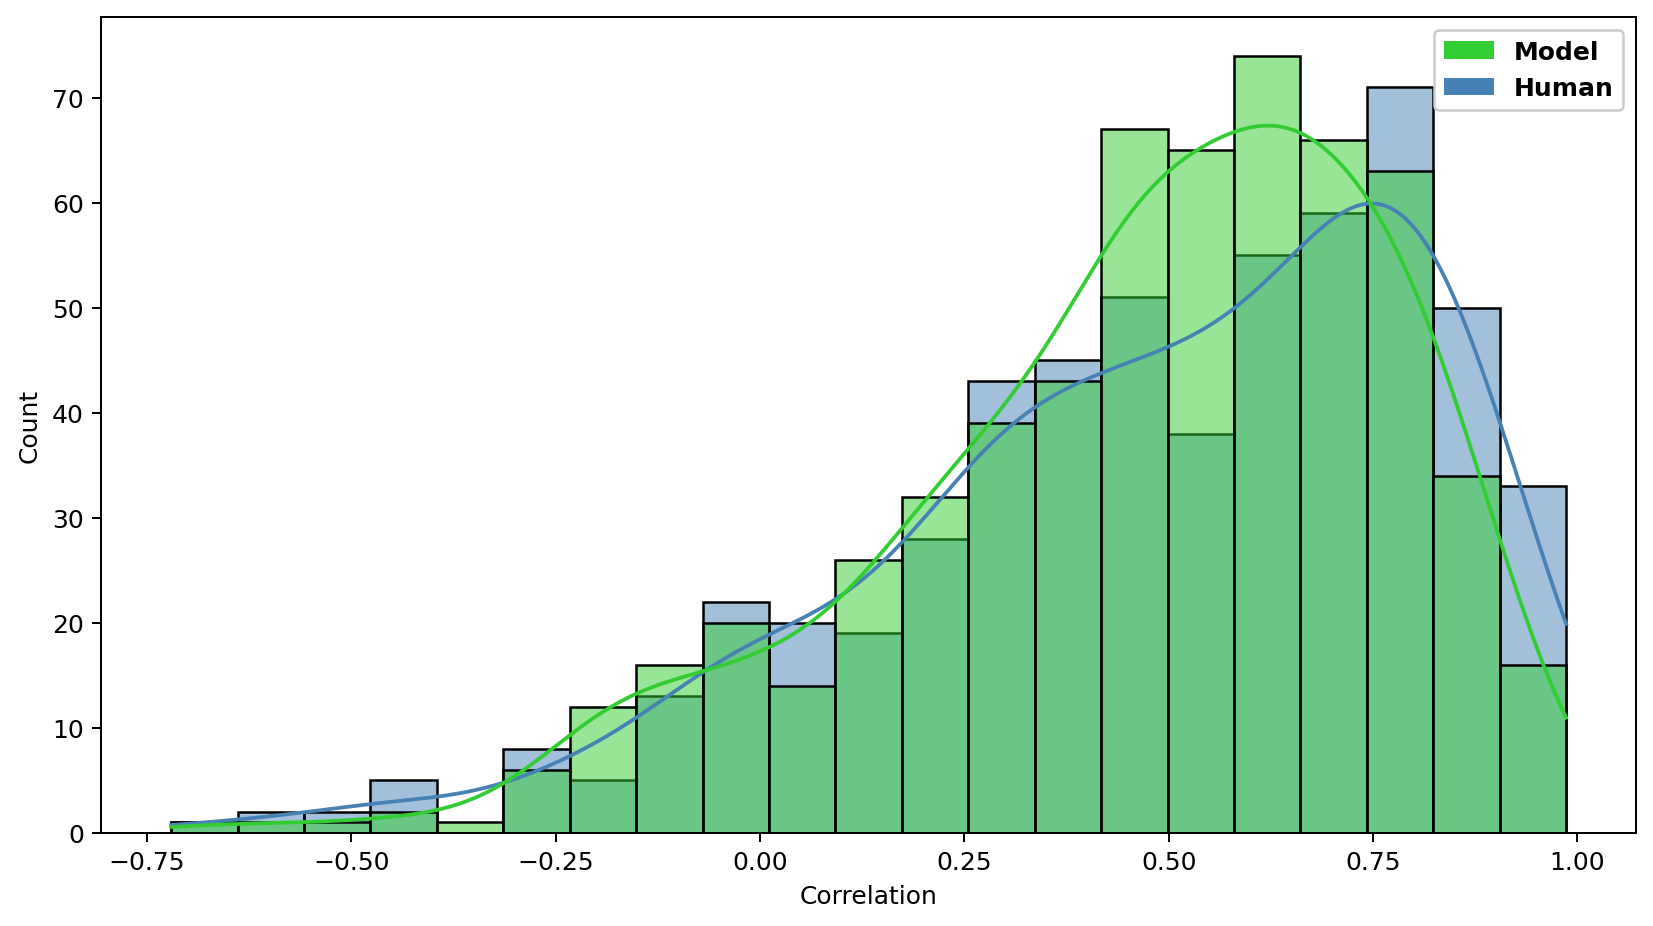

In [121]:
#Add the distribution plots for each data set:
fig  = plt.figure(figsize=(11, 6), dpi= 180)
palette=["limegreen","steelblue"]
ax = sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette)
from matplotlib.patches import Patch
handles = [Patch(facecolor=item) for item in palette]
labels = df_comparison.Predictor.unique().tolist()
ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

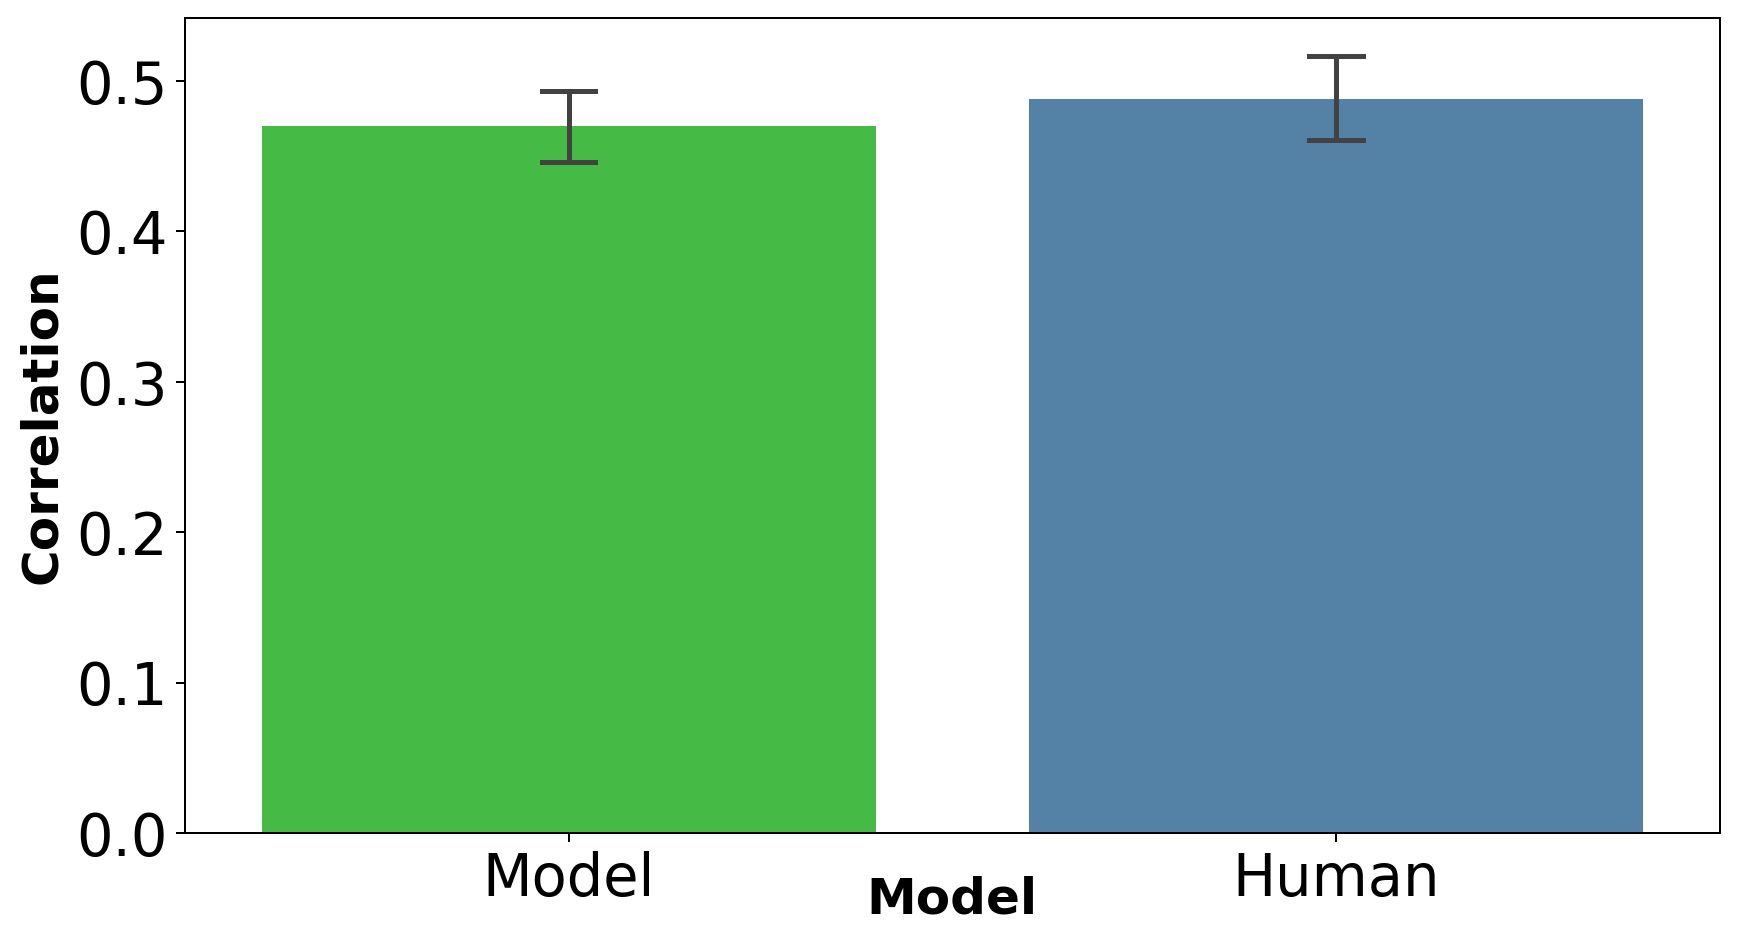

In [115]:
# create barplots
fig  = plt.figure(figsize=(11, 6), dpi= 180)
ax = sns.barplot(y='Correlation', x='Predictor', orient='v', data=df_comparison, ci=95, palette=["limegreen","steelblue"], capsize=0.07, errwidth=2)
plt.ylabel("Correlation", fontweight='bold', fontsize=20)
plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
# plt.title(dataset_names[i], fontsize=20)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

In [116]:
## distribution is skewed (towards better performance!)
## check where bulk of performance lies:
np.mean(df_comparison.Correlation[df_comparison.Predictor == "Model"]>0) # 91%+ of performances are positive
np.mean(df_comparison.Correlation.loc[(df_comparison.Predictor == "Model") & (df_comparison.Correlation>0.)]) # not a big difference!

0.5303566816174166

In [97]:
np.mean((df_comparison.Correlation[df_comparison.Predictor == "Human"]>0) & (df_comparison.pvalue[df_comparison.Predictor == "Model"]<0.05))

0.0